# Using xesmf to efficiently regrid data to another resolution

Often we want to compare to datasets but find that they are on different grids and first require to be interpolated to a common grid. 

There exist a number of different tools for doing this however in this post we'll talk about the regridding tools from xesmf.

First load the relevant packages

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np

Open the data. In this example, we will open a monthly surface temperature dataset from the ACCESS-1.3 CMIP5 model.

In [2]:
url = 'http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/mon/atmos/Amon/r1i1p1/latest/tas/tas_Amon_ACCESS1-3_historical_r1i1p1_185001-200512.nc'
ds = xr.open_dataset(url)

In [3]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 145, lon: 192, time: 1872)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2005-12-16T12:00:00
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/29)
    institution:                     CSIRO (Commonwealth Scientific and Indus...
    institute_id:                    CSIRO-BOM
    experiment_id:                   historical
    source:                          ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N...
    model_id:                        ACCESS1.3
    forcing:                         GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2,...
    ...                              ...
    title:                           ACCESS1-3 model output prepared for CMIP...
    parent_experiment:               pre-industrial control
    modeling_realm:                  atmos
    realization:                     1
    cmor_version:                    2.8.0
    DODS_EXTRA.Unlimited_Dimension:  time

For CMIP data the resolution may already be declared in the attributes of the file. If not, you can calculate this too:

In [4]:
(ds['lat'].max() - ds['lat'].min())/(ds['lat'].count()-1.)

<xarray.DataArray 'lat' ()>
array(1.25)
Coordinates:
    height   float64 1.5

In [5]:
(ds['lon'].max() - ds['lon'].min())/(ds['lon'].count()-1.)

<xarray.DataArray 'lon' ()>
array(1.875)
Coordinates:
    height   float64 1.5

So the original resolution is 1.25 degrees latitude by 1.875 degrees longitude

Say we want to regrid this to a 2.5 degree rectilinear grid, we can use the utils functions to define the new grid.

In [6]:
ds_out = xe.util.grid_2d(-180.0, 180.0, 2.5, -90.0, 90.0, 2.5)

In [7]:
ds_out

<xarray.Dataset>
Dimensions:  (x: 144, x_b: 145, y: 72, y_b: 73)
Coordinates:
    lon      (y, x) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
    lat      (y, x) float64 -88.75 -88.75 -88.75 -88.75 ... 88.75 88.75 88.75
    lon_b    (y_b, x_b) float64 -180.0 -177.5 -175.0 ... 175.0 177.5 180.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

Then we build the regridder. In this first instance, the weights are not saved to netcdf. Note that there are a few options for the regridding method. As we are working with a global dataset, we use `periodic=True` so that we do not get gaps along the central longitude

In [8]:
regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True)

In [9]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_145x192_72x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (145, 192) 
Output grid shape:          (72, 144) 
Periodic in longitude?      True

As this file contains near-surface air temperature we'll define this separately.

In [10]:
tas_original_resolution = ds['tas']

In [11]:
tas_original_resolution

<xarray.DataArray 'tas' (time: 1872, lat: 145, lon: 192)>
[52116480 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2005-12-16T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 1.5
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2012-02-05T23:49:51Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

Apply the regridder to the data

In [12]:
tas_25deg = regridder(tas_original_resolution)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [13]:
tas_25deg

<xarray.DataArray 'tas' (time: 1872, y: 72, x: 144)>
array([[[241.42548074, 241.46530151, 241.51575264, ..., 241.29264361,
         241.3331604 , 241.37937428],
        [249.29878775, 249.49865723, 249.70174442, ..., 248.53185656,
         248.81828308, 249.07307976],
        [258.90998768, 259.34362793, 259.62011489, ..., 257.00554583,
         257.77041626, 258.39012844],
        ...,
        [240.0256449 , 240.15310669, 240.28757747, ..., 239.80319719,
         239.92158508, 239.9827772 ],
        [239.95589676, 239.94976807, 239.9454768 , ..., 239.91784213,
         239.93392944, 239.96497476],
        [239.91920767, 239.95617676, 239.98541397, ..., 239.76462219,
         239.8212738 , 239.87550099]],

       [[235.35084386, 235.43763733, 235.53132127, ..., 235.12648029,
         235.19128418, 235.26917861],
        [247.80141914, 248.36372375, 248.88822159, ..., 246.27575141,
         246.73565674, 247.26041022],
        [257.63035803, 257.96582031, 258.17488678, ..., 256.06124283,
         256.6065979 , 257.11943182],
...
        [250.55788953, 250.56117249, 250.62096828, ..., 251.29435661,
         250.8780365 , 250.63096473],
        [252.6061043 , 252.39373779, 252.23463555, ..., 253.47047825,
         253.12278748, 252.8264588 ],
        [254.88175595, 254.8631897 , 254.86619789, ..., 255.01445768,
         254.97032166, 254.92613684]],

       [[246.75074031, 246.7674408 , 246.81818953, ..., 246.66889692,
         246.68983459, 246.7283168 ],
        [253.50811955, 253.73731995, 253.98962857, ..., 252.68888363,
         252.96813965, 253.25622345],
        [262.74184175, 263.19360352, 263.53787576, ..., 261.00175357,
         261.69522095, 262.25131706],
        ...,
        [245.47192229, 245.0090332 , 244.5782707 , ..., 246.80896796,
         246.32383728, 245.88781399],
        [246.79688785, 246.40936279, 246.01888102, ..., 247.81054793,
         247.51338196, 247.15659795],
        [245.98595642, 245.89811707, 245.81729825, ..., 246.27256695,
         246.18641663, 246.08195717]]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2005-12-16T12:00:00
    height   float64 1.5
    lon      (y, x) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
    lat      (y, x) float64 -88.75 -88.75 -88.75 -88.75 ... 88.75 88.75 88.75
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

Comparing the dimensions we have:

|  | time | lat | lon |
|:---:|:---:|:---:|:---:|
| tas_original_resolution | 1872 | 145 | 192 |
| tas_25deg | 1872 | 72 | 144

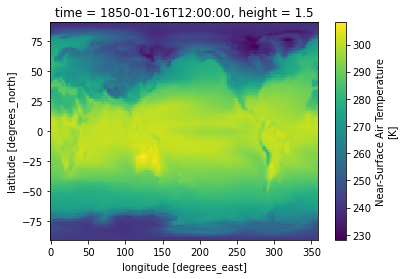

In [14]:
tas_original_resolution.isel(time=0).plot()

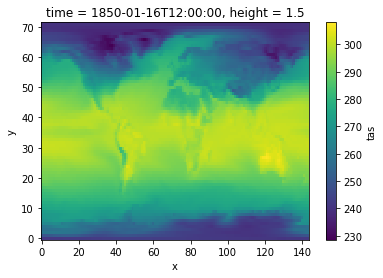

In [15]:
tas_25deg.isel(time=0).plot()

To save the weights for later use, you'll need to specify the filename to give to the weights file when you build the regridder for the first time:

In [16]:
regridder_save_weights = xe.Regridder(ds,ds_out,'bilinear',periodic=True,filename='bilinear_145x192_180x360_peri.nc')

In [17]:
regridder_save_weights

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_145x192_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (145, 192) 
Output grid shape:          (72, 144) 
Periodic in longitude?      True

This will save a file called bilinear_145x192_180x360_peri.nc into the directory you are running this notebook from.

To build the regridder using existing weights:

In [18]:
regridder_reuse_weights = xe.Regridder(ds,ds_out,'bilinear',periodic=True,reuse_weights=True,filename='bilinear_145x192_180x360_peri.nc')

In [19]:
regridder_reuse_weights

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_145x192_180x360_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (145, 192) 
Output grid shape:          (72, 144) 
Periodic in longitude?      True

Regridder will also work for 2D lat/lon that is common to curvilinear grids. In this case you'll need to create a new xr.Dataset containing the 2D lat/lon values from the grid you want to interpolate to. Often this can be done by copying the lat/lon from an existing file.

If you want to learn more about the different options available within xesmf please check out: https://xesmf.readthedocs.io/en/latest/